# Final Project

## Mark Haskins

### Import Libraries

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import neighbors, tree, naive_bayes
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from tabulate import tabulate
from sklearn import feature_selection
import pylab as pl
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
import sklearn.metrics as metrics
from sklearn.cluster import KMeans 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import completeness_score, homogeneity_score, accuracy_score
from sklearn import decomposition
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [53]:
stroke_df = pd.read_csv("healthcare-dataset-stroke-data.csv")

#### Basic descriptive statistics of the numeric attributes. 

In [54]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
stroke_df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.00,5110.00,5110.00,5110.00,5110.00,4909.00,5110.00
mean,36517.83,43.23,0.10,0.05,106.15,28.89,0.05
std,21161.72,22.61,0.30,0.23,45.28,7.85,0.22
min,67.00,0.08,0.00,0.00,55.12,10.30,0.00
25%,17741.25,25.00,0.00,0.00,77.25,23.50,0.00
50%,36932.00,45.00,0.00,0.00,91.88,28.10,0.00
75%,54682.00,61.00,0.00,0.00,114.09,33.10,0.00
max,72940.00,82.00,1.00,1.00,271.74,97.60,1.00


In [55]:
stroke_df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

#### Removing id column as not needed

In [56]:
stroke_df.drop('id', axis=1, inplace=True)

#### Producing Frequencies for Categorical Variables. Noticing Other was added for Gender so this was removed. 

In [57]:
cat_cols = stroke_df.select_dtypes(include=object).columns.tolist()
(pd.DataFrame(
    stroke_df[cat_cols]
    .melt(var_name='column', value_name='value')
    .value_counts())
.rename(columns={0: 'counts'})
.sort_values(by=['column', 'counts']))

counts
column         value                  
Residence_type Rural              2514
               Urban              2596
ever_married   No                 1757
               Yes                3353
gender         Other                 1
               Male               2115
               Female             2994
smoking_status smokes              789
               formerly smoked     885
               Unknown            1544
               never smoked       1892
work_type      Never_worked         22
               Govt_job            657
               children            687
               Self-employed       819
               Private            2925

In [58]:
otherGenderIndex = stroke_df[stroke_df['gender'] == 'Other'].index
stroke_df.drop(otherGenderIndex, inplace=True)

#### Finding Nulls

In [59]:
stroke_df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [60]:
males = stroke_df[stroke_df["gender"] == 'Male']
male_bmi_avg = males.bmi.mean()
male_bmi_avg

28.647936350074616

In [61]:
females = stroke_df[stroke_df["gender"] == 'Female']
female_bmi_avg = females.bmi.mean()
female_bmi_avg

29.065757680359038

#### Replacing Nulls with Male BMI mean and Female BMI mean

In [62]:
for i in stroke_df["gender"]:
    if i == 'Male':
        stroke_df["bmi"].fillna(male_bmi_avg, axis = 0, inplace = True)
    else:
        stroke_df["bmi"].fillna(female_bmi_avg, axis = 0, inplace = True)

In [63]:
stroke_df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [64]:
stroke_df = stroke_df.replace({'ever_married': {'Yes': 1, 'No': 0}})

#### Box plots to find outliers and look at distribution levels

<AxesSubplot:>

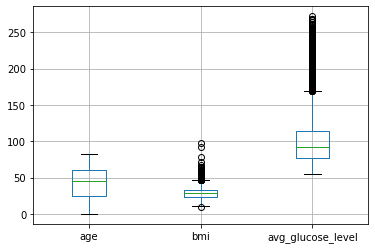

In [65]:
stroke_df.boxplot(column=["age","bmi","avg_glucose_level"], return_type='axes')

#### Histograms created for the non-binary numeric attributes for age, avg_gluclose_level and bmi. Age follows a normal standard distribution while avg_glucose_level and bmi are right skewed. 

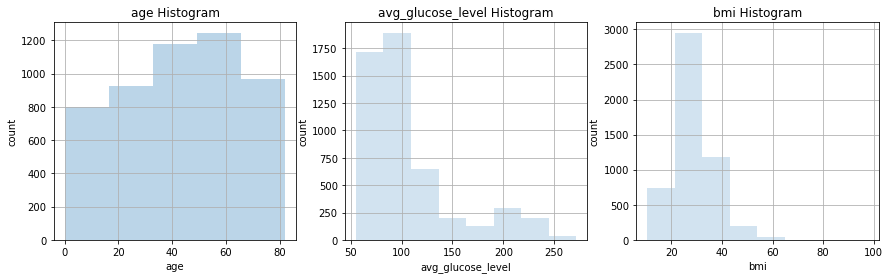

In [66]:
fig = plt.figure(figsize=(20, 4))
h1 = plt.subplot(1,4,1,)
h1.hist(stroke_df["age"], bins=5, alpha=0.3)
h1.set_xlabel('age')
h1.set_ylabel('count')
h1.set_title('age Histogram')
h1.grid(True)

h2 = plt.subplot(1,4,2)
h2.hist(stroke_df["avg_glucose_level"], bins=8, alpha=0.2)
h2.set_xlabel('avg_glucose_level')
h2.set_ylabel('count')
h2.set_title('avg_glucose_level Histogram')
h2.grid(True)

h3 = plt.subplot(1,4,3)
h3.hist(stroke_df["bmi"], bins=8, alpha=0.2)
h3.set_xlabel('bmi')
h3.set_ylabel('count')
h3.set_title('bmi Histogram')
h3.grid(True)

#### Creating dummy variables for later analysis

In [67]:
stroke_ssf = pd.get_dummies(stroke_df)
stroke_ssf.head(10)

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.00,0,1,1,228.69,36.60,1,0,1,0,0,1,0,0,0,1,0,1,0,0
1,61.00,0,0,1,202.21,28.65,1,1,0,0,0,0,1,0,1,0,0,0,1,0
2,80.00,0,1,1,105.92,32.50,1,0,1,0,0,1,0,0,1,0,0,0,1,0
3,49.00,0,0,1,171.23,34.40,1,1,0,0,0,1,0,0,0,1,0,0,0,1
4,79.00,1,0,1,174.12,24.00,1,1,0,0,0,0,1,0,1,0,0,0,1,0
5,81.00,0,0,1,186.21,29.00,1,0,1,0,0,1,0,0,0,1,0,1,0,0
6,74.00,1,1,1,70.09,27.40,1,0,1,0,0,1,0,0,1,0,0,0,1,0
7,69.00,0,0,0,94.39,22.80,1,1,0,0,0,1,0,0,0,1,0,0,1,0
8,59.00,0,0,1,76.15,28.65,1,1,0,0,0,1,0,0,1,0,1,0,0,0
9,78.00,0,0,1,58.57,24.20,1,1,0,0,0,1,0,0,0,1,1,0,0,0


In [68]:
stroke_corr_matrix = stroke_ssf.corr()
stroke_corr_matrix["stroke"].sort_values(ascending=False)

stroke                            1.00
age                               0.25
heart_disease                     0.13
avg_glucose_level                 0.13
hypertension                      0.13
ever_married                      0.11
smoking_status_formerly smoked    0.06
work_type_Self-employed           0.06
bmi                               0.04
Residence_type_Urban              0.02
work_type_Private                 0.01
gender_Male                       0.01
smoking_status_smokes             0.01
work_type_Govt_job                0.00
smoking_status_never smoked      -0.00
gender_Female                    -0.01
work_type_Never_worked           -0.01
Residence_type_Rural             -0.02
smoking_status_Unknown           -0.06
work_type_children               -0.08
Name: stroke, dtype: float64

In [69]:
age_bins = pd.qcut(stroke_ssf["age"], 5, labels=["very young", "young", "mid-age", "old", "very old"])
stroke_ssf["age-bins"] = age_bins
stroke_ssf.insert(0, "age-bins", stroke_ssf.pop("age-bins"))
stroke_ssf.drop('age', inplace = True, axis = 1)
stroke_ssf.head(10)

,age-bins,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,very old,0,1,1,228.69,36.60,1,0,1,0,0,1,0,0,0,1,0,1,0,0
1,old,0,0,1,202.21,28.65,1,1,0,0,0,0,1,0,1,0,0,0,1,0
2,very old,0,1,1,105.92,32.50,1,0,1,0,0,1,0,0,1,0,0,0,1,0
3,mid-age,0,0,1,171.23,34.40,1,1,0,0,0,1,0,0,0,1,0,0,0,1
4,very old,1,0,1,174.12,24.00,1,1,0,0,0,0,1,0,1,0,0,0,1,0
5,very old,0,0,1,186.21,29.00,1,0,1,0,0,1,0,0,0,1,0,1,0,0
6,very old,1,1,1,70.09,27.40,1,0,1,0,0,1,0,0,1,0,0,0,1,0
7,very old,0,0,0,94.39,22.80,1,1,0,0,0,1,0,0,0,1,0,0,1,0
8,old,0,0,1,76.15,28.65,1,1,0,0,0,1,0,0,1,0,1,0,0,0
9,very old,0,0,1,58.57,24.20,1,1,0,0,0,1,0,0,0,1,1,0,0,0


#### Creating target labels for classification

In [70]:
stroke_ssf1 = pd.get_dummies(stroke_ssf)
stroke_lables = stroke_ssf1.stroke
stroke_df = stroke_ssf1.drop('stroke', axis = 1)

#### Creating test and train data using an 80-20 split

In [71]:
stroke_train, stroke_test, stroke_target_train, stroke_target_test = train_test_split(stroke_df, stroke_lables, test_size=0.2, random_state=42)

## Supervised Technique - Classification

### KNN Classifier

#### Normalizing Data

In [72]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(stroke_train)
stroke_train_norm = min_max_scaler.fit_transform(stroke_train)
stroke_train_norm= pd.DataFrame(stroke_train_norm, columns=stroke_train.columns, index=stroke_train.index)
stroke_test_norm = min_max_scaler.fit_transform(stroke_test)
stroke_test_norm = pd.DataFrame(stroke_test_norm, columns=stroke_test.columns, index=stroke_test.index)

In [73]:
distance = []
for K in range(2, 105, 5):
    knnclfD = neighbors.KNeighborsClassifier(K, weights='distance')
    knnclfD.fit(stroke_train_norm,stroke_target_train)
    distance.append(knnclfD.score(stroke_test_norm, stroke_target_test))
uniform = []
for K in range(2, 105, 5):
    knnclfU = neighbors.KNeighborsClassifier(K, weights='uniform')
    knnclfU.fit(stroke_train_norm,stroke_target_train)
    uniform.append(knnclfU.score(stroke_test_norm, stroke_target_test))

#### Comparing distance vs uniform weights over a range of 100 values of K for the nearest neighbors

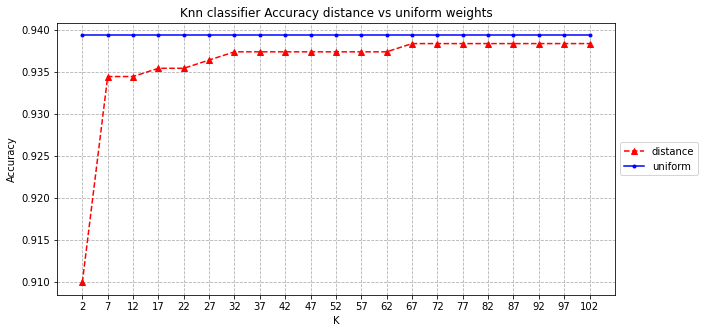

In [74]:
Ks=list(range(2, 105, 5))
plt.figure(figsize=(10,5))
plt.plot(Ks, distance, 'r^--', label='distance')
plt.plot(Ks, uniform, 'b.-', label='uniform')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Knn classifier Accuracy distance vs uniform weights')
plt.grid(linestyle='--')
plt.xticks(Ks)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### Performing Cross Validation using K = 67 to produce overall accuracy. This is repeated again for the Naive Bayes Classifier and Linear Discriminant Analysis Classifier

In [75]:
K = 67
knnclfB = neighbors.KNeighborsClassifier(K, weights='uniform')
knnclfB.fit(stroke_train_norm,stroke_target_train)
cv_scores_nb_train = cross_val_score(knnclfB, stroke_train_norm, stroke_target_train, cv=10)
ovaT_knn = cv_scores_nb_train.mean()
Tr_knn = knnclfB.score(stroke_train_norm, stroke_target_train)
Te_knn = knnclfB.score(stroke_test_norm, stroke_target_test)

### Naive Bayes (Gaussian) Classifier

In [76]:
nbclf = naive_bayes.GaussianNB()
nbclf = nbclf.fit(stroke_train, stroke_target_train)
cv_scores_nb_train = cross_val_score(nbclf, stroke_train, stroke_target_train, cv=10)
ovaT_nb = cv_scores_nb_train.mean()
Tr_nb = nbclf.score(stroke_train, stroke_target_train)
Te_nb = nbclf.score(stroke_test, stroke_target_test)

### Linear Discriminant Analysis Classifier

In [78]:
ldclf = LinearDiscriminantAnalysis()
ldclf = ldclf.fit(stroke_train, stroke_target_train)
cv_scores_ld_train = cross_val_score(ldclf, stroke_train, stroke_target_train, cv=10)
ovaT_lca = cv_scores_ld_train.mean()
Tr_lca = ldclf.score(stroke_train, stroke_target_train)
Te_lca = ldclf.score(stroke_test, stroke_target_test)

#### Table showing the overall Accuracy, Training Accuracy, Test Accuracy and difference between Train-Test accuracy for signs of overfitting. KNN Classifer and LCA Classifer seem to perform similary. 

In [79]:
data = [["KNN", ovaT_knn, Tr_knn, Te_knn, Tr_knn-Te_knn], 
        ["Naive Bayes", ovaT_nb, Tr_nb, Te_nb, Tr_nb-Te_nb], 
        ["LCA", ovaT_lca, Tr_lca, Te_lca, Tr_lca - Te_lca]]
col_names = ["Classifier", "Overall Accuracy", 'Training Accuracy', 'Test Accruacy', 'Train-Test' ]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid",  floatfmt=".2f"))

╒══════════════╤════════════════════╤═════════════════════╤═════════════════╤══════════════╕
│ Classifier   │   Overall Accuracy │   Training Accuracy │   Test Accruacy │   Train-Test │
╞══════════════╪════════════════════╪═════════════════════╪═════════════════╪══════════════╡
│ KNN          │               0.95 │                0.95 │            0.94 │         0.01 │
├──────────────┼────────────────────┼─────────────────────┼─────────────────┼──────────────┤
│ Naive Bayes  │               0.56 │                0.57 │            0.56 │         0.01 │
├──────────────┼────────────────────┼─────────────────────┼─────────────────┼──────────────┤
│ LCA          │               0.95 │                0.95 │            0.93 │         0.01 │
╘══════════════╧════════════════════╧═════════════════════╧═════════════════╧══════════════╛


## Supervised Technique - Regression

### Linear Regression

In [80]:
linreg = LinearRegression()
lr = linreg.fit(stroke_train_norm,stroke_target_train)
cv_scores_lr_train = cross_val_score(lr, stroke_train_norm, stroke_target_train, cv=10, scoring='neg_mean_absolute_error')
ovaT_lr = cv_scores_lr_train.mean()
ovaT_lr = abs(ovaT_lr)
Tr_lr = lr.score(stroke_train_norm, stroke_target_train)
Te_lr = lr.score(stroke_test_norm, stroke_target_test)

In [81]:
def optimal_percent(model, X, y, n):        
    percentiles = range(1, 100, 5)
    results = []
    for i in range(1, 100, 5):
        fs = feature_selection.SelectPercentile(feature_selection.f_regression, percentile=i)
        X_train_fs = fs.fit_transform(X , y)
        scores = cross_val_score(model, X_train_fs, y, cv=n, scoring='neg_mean_absolute_error')
        scores = abs(scores)
        results = np.append(results, scores.mean())
    optimal_percentile_ind = np.where(results == results.min())[0][0]
    opt = percentiles[optimal_percentile_ind]
    return opt, percentiles, results

In [82]:
def measure_performance(X, y, model, metric = metrics.mean_absolute_error):
    y_pred = model.predict(X)
    score = metric(y, y_pred)
    return score

#### Using Feature Selection - 16% or 4 out of the 23 varables are the optimal number of features. 

In [83]:
o,p,r = optimal_percent(lr, stroke_train_norm, stroke_target_train, 5)
print(o)
print('Optimal % of Features: ' + str(o) + "%")

16
Optimal % of Features: 16%


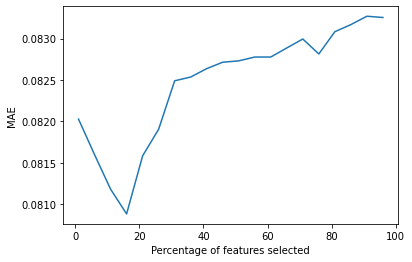

In [84]:
pl.figure()
pl.xlabel("Percentage of features selected")
pl.ylabel("MAE")
pl.plot(p,r)
pl.show()

In [85]:
fs = feature_selection.SelectPercentile(feature_selection.f_regression, percentile=o)
X_train_fs = fs.fit_transform(stroke_train, stroke_target_train)
features = stroke_df.columns.values.tolist()
num_fs = len(stroke_df.columns[fs.get_support()].values)

In [86]:
linreg = LinearRegression()
lrFS = linreg.fit(X_train_fs, stroke_target_train)
X_test_fs = fs.transform(stroke_test)
cv_scores_lrFS_train = cross_val_score(lrFS, X_train_fs, stroke_target_train, cv=10, scoring='neg_mean_absolute_error')
ovaT_lrFS = cv_scores_lrFS_train.mean()
ovaT_lrFS = abs(ovaT_lrFS)
Tr_lrFS = lrFS.score(X_train_fs, stroke_target_train)
Te_lrFS = lrFS.score(X_test_fs, stroke_target_test)

In [87]:
def calc_params(X, y, clf, param_values, param_name, K):
    X = np.array(X)
    y = np.array(y)

    train_scores = np.zeros(len(param_values))
    test_scores = np.zeros(len(param_values))
    
    for i, param_value in enumerate(param_values):       

        clf.set_params(**{param_name:param_value})
        
        k_train_scores = np.zeros(K)
        k_test_scores = np.zeros(K)
        
        cv = KFold(n_splits=K, shuffle=True, random_state=0)
        
        j = 0
        for train, test in cv.split(X):
            clf.fit(X[train], y[train])
            k_train_scores[j] = np.sqrt(measure_performance(X[train], y[train], clf, metric=metrics.mean_squared_error))
            k_test_scores[j] = np.sqrt(measure_performance(X[test], y[test], clf, metric=metrics.mean_squared_error))
            j += 1
            
        train_scores[i] = np.mean(k_train_scores)
        test_scores[i] = np.mean(k_test_scores)
       
    plt.plot(param_values, train_scores, label='Train')#, alpha=0.4, lw=2, c='b')
    plt.plot(param_values, test_scores, label='X-Val')#, alpha=0.4, lw=2, c='g')
    plt.legend(loc=7)
    plt.xlabel(param_name + " values")
    plt.ylabel("Mean Cross Validation RMSE")
    plt.show()

    return train_scores, test_scores

### Lasso Regression

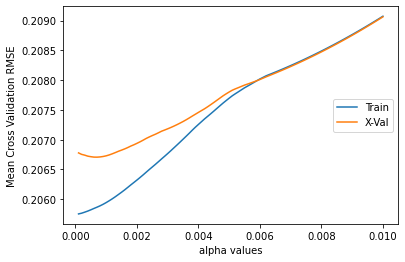

In [88]:
lasso = Lasso()
al = np.linspace(.0001,.01,100)
train_scores, test_scores = calc_params(stroke_df, stroke_lables, lasso, al, 'alpha', 5)

In [89]:
lassoO = Lasso(alpha=0.0001)
lassoO.fit(stroke_train, stroke_target_train)
lassoTr_mae = measure_performance(stroke_train, stroke_target_train, lassoO)
lassoTe_mae = measure_performance(stroke_test, stroke_target_test, lassoO)

### Ridge Regression

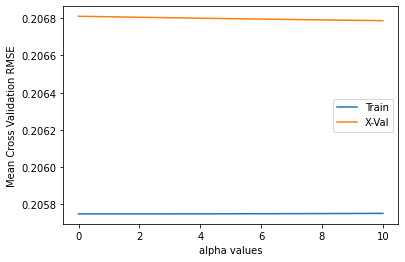

In [90]:
ridge = Ridge()
ar = np.linspace(.001,10,100)
train_scores, test_scores = calc_params(stroke_df, stroke_lables, ridge, ar, 'alpha', 5)

In [91]:
ridgeO = Ridge(alpha=5)
ridgeO.fit(stroke_train, stroke_target_train)
ridgeTr_mae = measure_performance(stroke_train, stroke_target_train, ridgeO)
ridgeTe_mae = measure_performance(stroke_test, stroke_target_test, ridgeO)

In [92]:
data = [["Linear", Tr_lr, Te_lr, Tr_lr-Te_lr, "Num Features: " + str(len(features))], 
        ["Linear FS", Tr_lrFS, Te_lrFS, Tr_lrFS-Te_lrFS, "Num Features: " + str(num_fs)], 
        ["Lasso", lassoTr_mae, lassoTe_mae, lassoTr_mae - lassoTe_mae, "Alpha: 0.0001"],
        ["Ridge", ridgeTr_mae, ridgeTe_mae, ridgeTr_mae - ridgeTe_mae, "Alpha: 5"]]
col_names = ["Regression Type", 'Training MAE', 'Test MAE', 'Train-Test','Parameters' ]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid",  floatfmt=".4f"))

╒═══════════════════╤════════════════╤════════════╤══════════════╤══════════════════╕
│ Regression Type   │   Training MAE │   Test MAE │   Train-Test │ Parameters       │
╞═══════════════════╪════════════════╪════════════╪══════════════╪══════════════════╡
│ Linear            │         0.0811 │     0.0929 │      -0.0118 │ Num Features: 23 │
├───────────────────┼────────────────┼────────────┼──────────────┼──────────────────┤
│ Linear FS         │         0.0740 │     0.0868 │      -0.0128 │ Num Features: 4  │
├───────────────────┼────────────────┼────────────┼──────────────┼──────────────────┤
│ Lasso             │         0.0824 │     0.0966 │      -0.0141 │ Alpha: 0.0001    │
├───────────────────┼────────────────┼────────────┼──────────────┼──────────────────┤
│ Ridge             │         0.0827 │     0.0968 │      -0.0142 │ Alpha: 5         │
╘═══════════════════╧════════════════╧════════════╧══════════════╧══════════════════╛


## Unsupervised Technique - Clustering

In [93]:
def cluster_sizes(clusters):  
    size = {}
    cluster_labels = np.unique(clusters)
    n_clusters = cluster_labels.shape[0]

    for c in cluster_labels:
        size[c] = len(clusters[clusters == c])
    return size

In [94]:
scaler = MinMaxScaler()
model=scaler.fit(stroke_df)
scaled_stroke_df = model.transform(stroke_df)
kmeans = KMeans(n_clusters=2,  random_state = 42)
kmeans.fit(scaled_stroke_df)
clusters = kmeans.predict(scaled_stroke_df)

In [95]:
labs = stroke_ssf1['stroke']
c1 = completeness_score(labs,clusters)
h = homogeneity_score(labs,clusters)
a = accuracy_score(labs, clusters)
size = cluster_sizes(clusters)

## Unsupervised Technique - PCA

[0.17 0.14 0.14 0.1  0.08 0.06 0.06 0.05 0.05 0.04 0.04 0.02 0.02 0.01 0.01 0.01 0.   0.   0.   0.   0.   0.   0.  ]


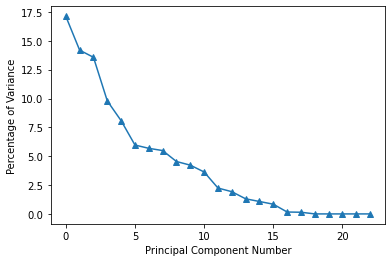

In [96]:
np.set_printoptions(precision=2,suppress=True, edgeitems=5, linewidth=120)
pca = decomposition.PCA()
scaled_stroke_df_pca = pca.fit(scaled_stroke_df).transform(scaled_stroke_df)
print(pca.explained_variance_ratio_)
varPercentage = pca.explained_variance_ratio_*100
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(23), varPercentage[:], marker='^')
plt.xlabel('Principal Component Number')
plt.ylabel('Percentage of Variance')
plt.show()

In [97]:
count = 0
sum = 0
for v in pca.explained_variance_ratio_:
    if sum < .90:
        sum = sum+v
        count+=1
print("Total Variance: "+ str(sum))
print("Principle Components: "+ str(count))     

Total Variance: 0.9229607541396982
Principle Components: 11


In [98]:
scaled_stroke_df_pca_reduced = scaled_stroke_df_pca[:,:11]
kmeans = KMeans(n_clusters=2,  random_state = 42)
kmeans.fit(scaled_stroke_df_pca_reduced)
clusters_pca = kmeans.predict(scaled_stroke_df_pca_reduced)

In [99]:
labs = stroke_ssf1['stroke']
c_pca = completeness_score(labs,clusters_pca )
h_pca = homogeneity_score(labs,clusters_pca)
a_pca = accuracy_score(labs, clusters_pca)
size_pca = cluster_sizes(clusters_pca)

In [100]:
data = [["Cluster", c1, h, a, size[0], size[1]], 
        ["Cluster PCA", c_pca, h_pca, a_pca,size_pca[0], size_pca[1]]]
col_names = ["Type", 'Completeness', 'Homogeneity', 'Accuracy', 'Cluster Size 0', 'Cluster Size 1']
print(tabulate(data, headers=col_names, tablefmt="fancy_grid",  floatfmt=".4f"))

╒═════════════╤════════════════╤═══════════════╤════════════╤══════════════════╤══════════════════╕
│ Type        │   Completeness │   Homogeneity │   Accuracy │   Cluster Size 0 │   Cluster Size 1 │
╞═════════════╪════════════════╪═══════════════╪════════════╪══════════════════╪══════════════════╡
│ Cluster     │         0.0002 │        0.0006 │     0.5040 │             2596 │             2513 │
├─────────────┼────────────────┼───────────────┼────────────┼──────────────────┼──────────────────┤
│ Cluster PCA │         0.0002 │        0.0006 │     0.4960 │             2513 │             2596 │
╘═════════════╧════════════════╧═══════════════╧════════════╧══════════════════╧══════════════════╛


In [101]:
y = stroke_ssf1['stroke']
X = stroke_df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [102]:
def measure_performance(X, y, clf, show_accuracy=True, show_classification_report=True, show_confussion_matrix=True):
    y_pred = clf.predict(X)   
    if show_accuracy:
         print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y, y_pred)),"\n")
    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y, y_pred),"\n")
      
    if show_confussion_matrix:
        print("Confussion matrix")
        print(metrics.confusion_matrix(y, y_pred),"\n")

### Decision Tree - Classifier 

dt = tree.DecisionTreeClassifier(criterion='gini')
dt = dt.fit(X_train, y_train)
measure_performance(X_test, y_test, dt, show_confussion_matrix=False, show_classification_report=False)

In [103]:
rf = RandomForestClassifier(n_estimators=10, random_state=33)
rf = rf.fit(X_train, y_train)
measure_performance(X_test, y_test, rf, show_confussion_matrix=False, show_classification_report=False)

Accuracy:0.933 



In [104]:
print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 33, 'verbose': 0, 'warm_start': False}


In [105]:
def calc_params(X, y, clf, param_values, param_name, K):
    
    # Convert input to Numpy arrays
    X = np.array(X)
    y = np.array(y)

    # initialize training and testing score arrays with zeros
    train_scores = np.zeros(len(param_values))
    test_scores = np.zeros(len(param_values))
    
    # iterate over the different parameter values
    for i, param_value in enumerate(param_values):

        # set classifier parameters
        clf.set_params(**{param_name:param_value})
        
        # initialize the K scores obtained for each fold
        k_train_scores = np.zeros(K)
        k_test_scores = np.zeros(K)
        
        # create KFold cross validation
        cv = KFold(n_splits=K, shuffle=True, random_state=0)
        
        # iterate over the K folds
        j = 0
        for train, test in cv.split(X):
            # fit the classifier in the corresponding fold
            # and obtain the corresponding accuracy scores on train and test sets
            clf.fit(X[train], y[train])
            k_train_scores[j] = clf.score(X[train], y[train])
            k_test_scores[j] = clf.score(X[test], y[test])
            j += 1
            
        # store the mean of the K fold scores
        train_scores[i] = np.mean(k_train_scores)
        test_scores[i] = np.mean(k_test_scores)
        print(param_name, '=', param_value, "Train =", train_scores[i], "Test =", test_scores[i])
       
    # plot the training and testing scores in a log scale
    plt.plot(param_values, train_scores, label='Train', alpha=0.4, lw=2, c='b')
    plt.plot(param_values, test_scores, label='X-Val', alpha=0.4, lw=2, c='g')
    plt.legend(loc=7)
    plt.xlabel(param_name + " values")
    plt.ylabel("Mean cross validation accuracy")

    # return the training and testing scores on each parameter value
    return train_scores, test_scores

### Ensemble Method - Random Forest

min_samples_leaf = 1 Train = 0.9914975915911027 Test = 0.9498397440693335
min_samples_leaf = 2 Train = 0.9623195938493663 Test = 0.9515527318324242
min_samples_leaf = 3 Train = 0.9558966774341113 Test = 0.9527767220405025
min_samples_leaf = 4 Train = 0.9539393225022756 Test = 0.9532663181237337
min_samples_leaf = 5 Train = 0.9536334372658362 Test = 0.9535108169012398


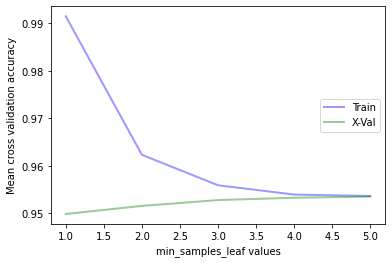

In [106]:
msl = range(1,6)
rf = RandomForestClassifier(n_estimators=10, random_state=33)
train_scores, test_scores = calc_params(X_train, y_train, rf, msl, 'min_samples_leaf', 5)

In [107]:
#4 is the best

max_depth = 1 Train = 0.9535111131068147 Test = 0.9535108169012398
max_depth = 2 Train = 0.9535111131068147 Test = 0.9535108169012398
max_depth = 3 Train = 0.9535111131068147 Test = 0.9535108169012398
max_depth = 4 Train = 0.9535111131068147 Test = 0.9535108169012398
max_depth = 5 Train = 0.954061609241854 Test = 0.9535108169012398
max_depth = 6 Train = 0.9540005032915078 Test = 0.9535108169012398
max_depth = 7 Train = 0.9552850379292828 Test = 0.9535108169012398
max_depth = 8 Train = 0.9592612092280088 Test = 0.9535105176371304


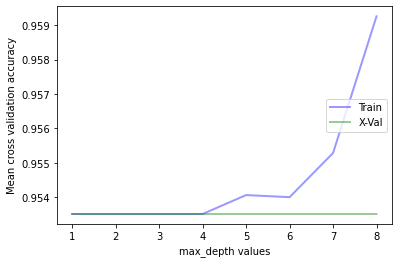

In [108]:
m_depth = [1,2,3,4,5,6, 7, 8]
rf = RandomForestClassifier(n_estimators=10, random_state=33)
train_scores, test_scores = calc_params(X_train, y_train, rf, m_depth, 'max_depth', 5)

n_estimators = 5 Train = 0.9902130382436061 Test = 0.9415210996160441
n_estimators = 10 Train = 0.9914975915911027 Test = 0.9498397440693335
n_estimators = 15 Train = 0.9963299758738142 Test = 0.9493516443066501
n_estimators = 20 Train = 0.9951065284766638 Test = 0.9500848413750587
n_estimators = 25 Train = 0.9973696750963317 Test = 0.949840043333443
n_estimators = 30 Train = 0.9976143421240959 Test = 0.9508192354999057
n_estimators = 35 Train = 0.998715427942782 Test = 0.9498406418616622
n_estimators = 40 Train = 0.9987154466525034 Test = 0.9498409411257718
n_estimators = 45 Train = 0.999388304366007 Test = 0.9498403425975527
n_estimators = 50 Train = 0.9992659802069855 Test = 0.9505750359865092
n_estimators = 55 Train = 0.9995106659444714 Test = 0.9505744374582902
n_estimators = 60 Train = 0.9996941521830035 Test = 0.9508192354999059
n_estimators = 65 Train = 0.9998776571312572 Test = 0.9505744374582902
n_estimators = 70 Train = 0.9996941521830035 Test = 0.9513091308472467
n_estimato

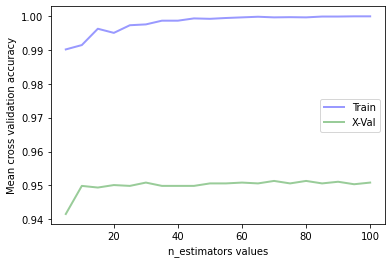

In [109]:
nest = range(5, 101, 5)
rf = RandomForestClassifier(n_estimators=10, random_state=33)
train_scores, test_scores = calc_params(X_train, y_train, rf, nest, 'n_estimators', 5)

In [110]:
#15
rf = RandomForestClassifier(n_estimators=15, min_samples_leaf=4, max_depth=4)
rf = rf.fit(X_train, y_train)
measure_performance(X_test, y_test, rf, show_confussion_matrix=False, show_classification_report=False)

Accuracy:0.942 



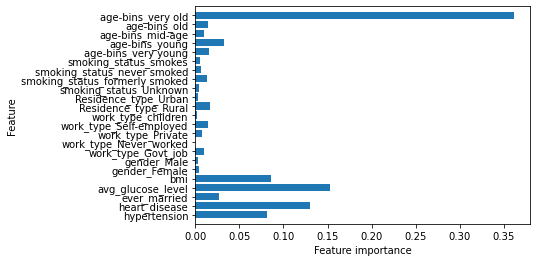

In [111]:
def plot_feature_importances(model, n_features, feature_names):
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

stroke_df_col = stroke_df.columns.values
features = stroke_df_col
plot_feature_importances(rf, len(features), features)

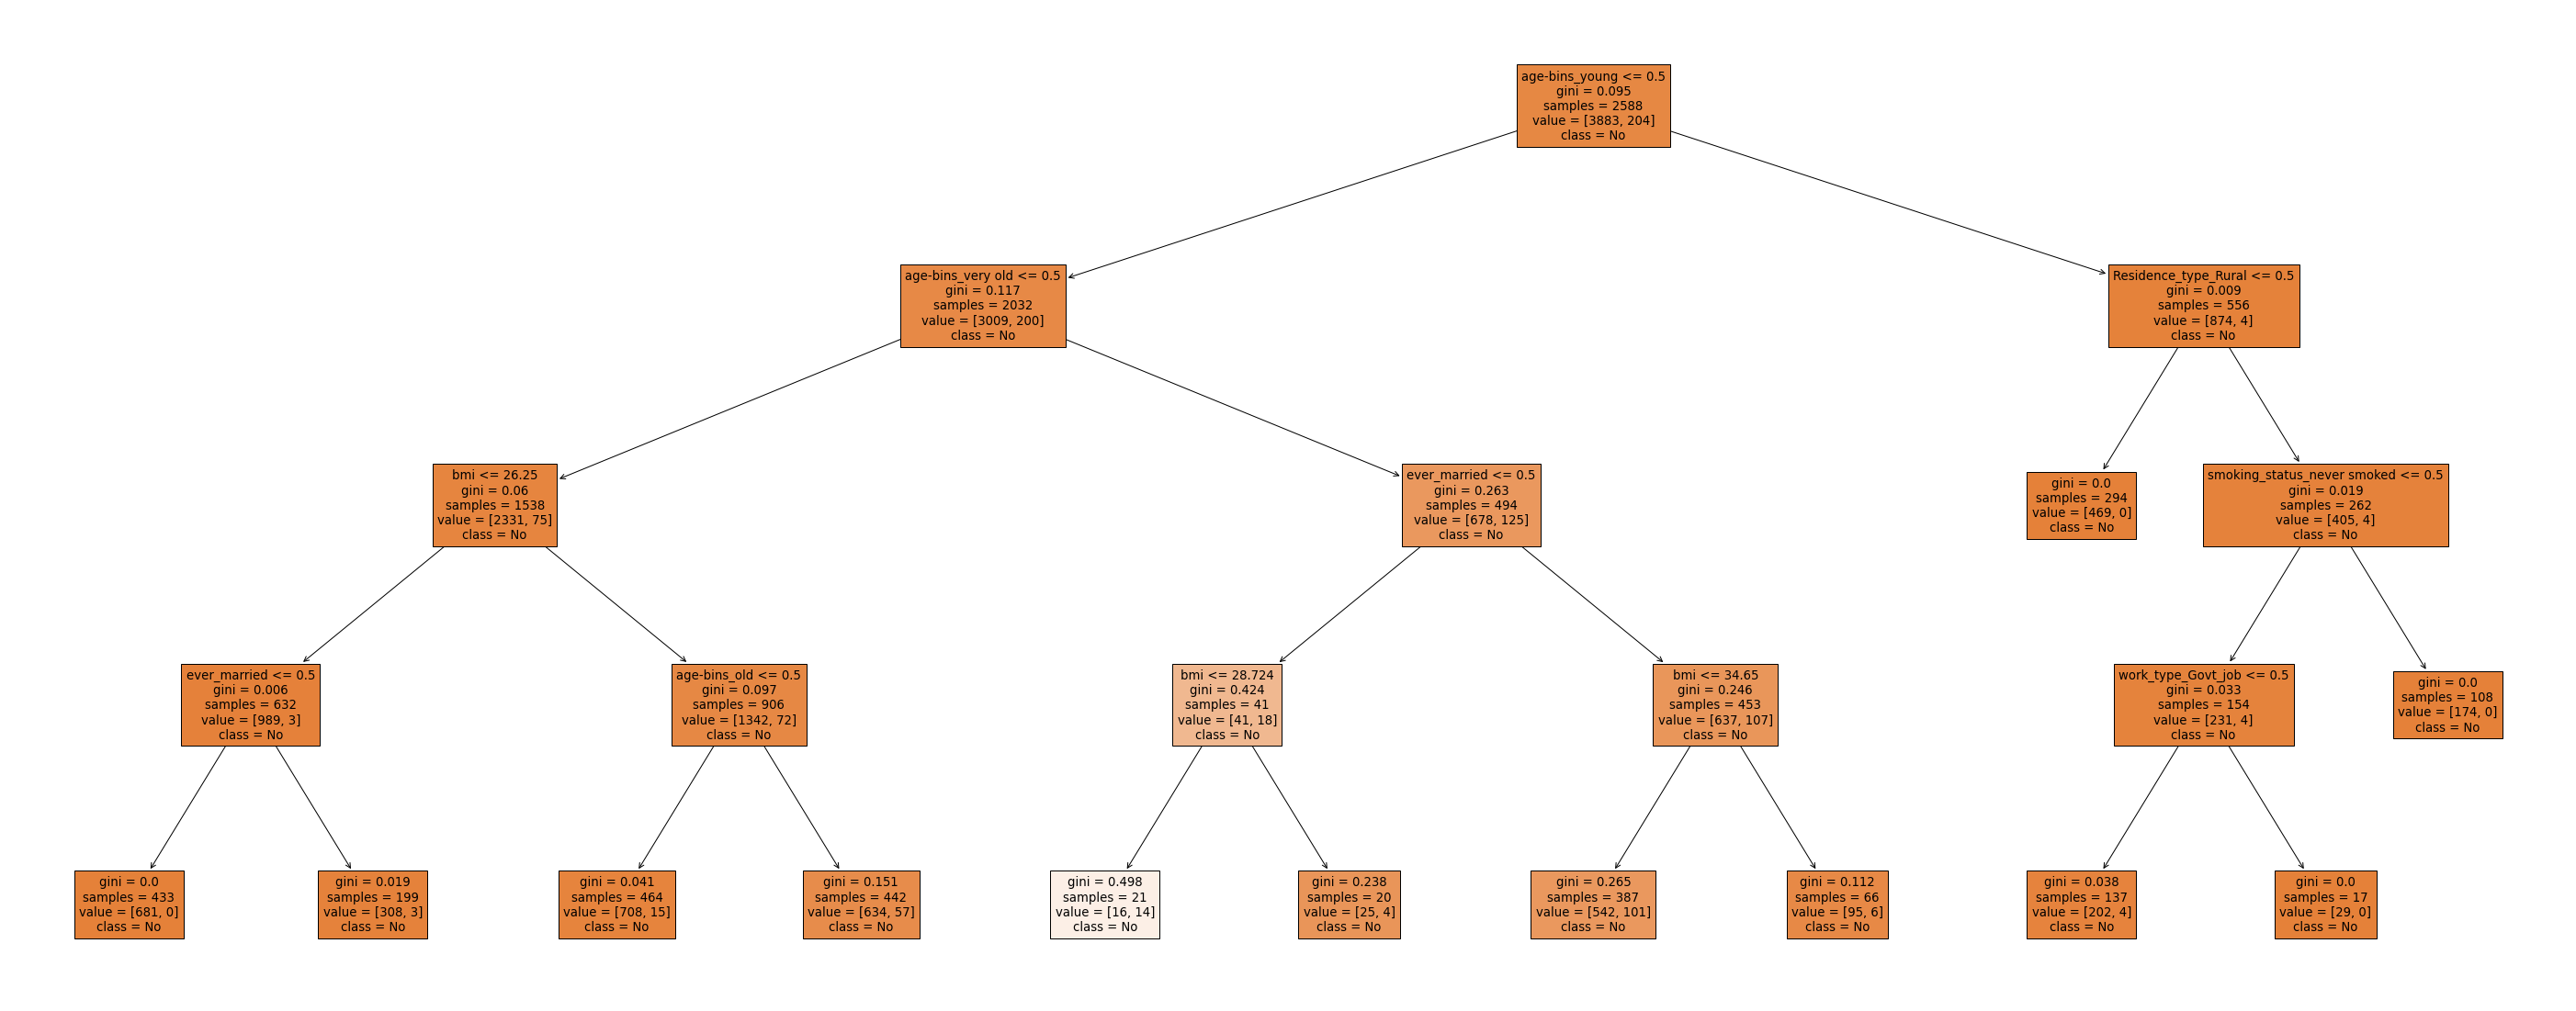

In [112]:
fig, ax = plt.subplots(figsize=(50,20))
tree.plot_tree(rf.estimators_[0], feature_names=features, class_names=["No","Yes"], filled=True, ax=ax);

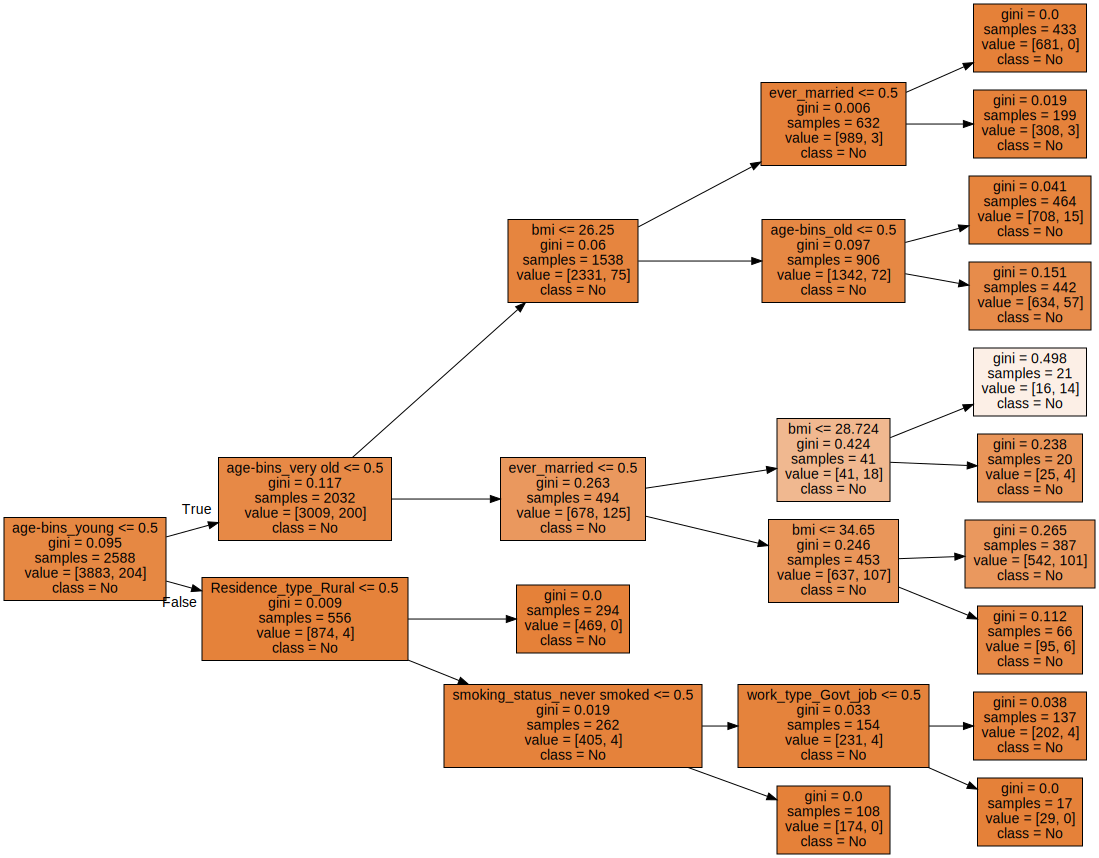

In [113]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(rf.estimators_[0],out_file=None, feature_names=features, 
                           class_names=["No","Yes"], filled=True, rotate=True)
graph = graphviz.Source(dot_data)
graph